# I. Overview

## 1.1) Dataset overview - Tiki Books Dataset

**Data Books of Tiki E-commerce in Vietnam**

**About this dataset This dataset contains information on 2,024 bestselling books:**

+ product_id:	id of the product in the Tiki database (unique)
+ title: 	name of the book, maybe contain republish time
+ authors: 	same with it's name
+ original_price: 	price at the first time
+ current_price: 	price at present if having a discount
+ quantity: 	total number of books sold of all time
+ category: 	kind of book
+ n_review: 	number of reviews
+ avg_rating: 	average rating (max 5.0)
+ pages: 	total pages of each book

## 1.2) Define Problems and highlevel approach

Offline bookstores often rely on intuition when deciding which books to stock and in what quantity. This project builds an end-to-end machine learning system that uses historical sales data from the Tiki e-commerce platform as a proxy for market demand.

+ **Model input** consists of book attributes such as category, price, rating, number of reviews, and number of pages.
+ **Model output** is the predicted sales quantity. However, due to high variance and data limitations, exact sales prediction is inherently noisy. Therefore, predicted quantities are further mapped into **demand levels** (Low, Medium, High).

Rather than replacing human decision-making, the model is designed as a decision-support indicator. The demand level output helps bookstore owners compare books, prioritize inbound selections, and make more informed stocking decisions, while final judgment remains with the store owner. The system is deployed as an API and a simple web application, with a brief comparison between traditional machine learning models and a neural network as a bonus experiment.

**Approach:**

The model learns demand patterns from historical book sales by relating pricing, product attributes, and customer feedback to observed sales quantity. A regularized regression model is used to balance predictive performance and robustness, while outputs are translated into demand levels to reduce noise and improve decision usability. This approach allows bookstore owners to compare books and prioritize inbound decisions based on a consistent demand signal rather than exact sales forecasts.



In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score


# II. Data Processing


### 2.1 Load and Inspect Data

In [10]:
#load_data
df = pd.read_csv("book_data.csv")

pd.options.display.float_format = '{:.2f}'.format

In [11]:
# Drop duplicates
df = df.drop_duplicates()

In [21]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1777 entries, 0 to 1795
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      1777 non-null   int64  
 1   title           1777 non-null   object 
 2   authors         1637 non-null   object 
 3   original_price  1777 non-null   int64  
 4   current_price   1777 non-null   int64  
 5   quantity        1732 non-null   float64
 6   category        1777 non-null   object 
 7   n_review        1777 non-null   int64  
 8   avg_rating      1777 non-null   float64
 9   pages           1527 non-null   object 
 10  manufacturer    1512 non-null   object 
 11  cover_link      1777 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 180.5+ KB


In [22]:
df.describe()

,product_id,original_price,current_price,quantity,n_review,avg_rating
count,1777.00,1777.00,1777.00,1732.00,1777.00,1777.00
mean,116368080.85,158642.31,115331.58,2796.83,327.10,4.58
std,72564731.90,127005.99,101779.11,16965.80,729.26,1.15
min,335337.00,0.00,0.00,1.00,0.00,0.00
25%,52785564.00,89000.00,60000.00,173.00,16.00,4.80
50%,115078649.00,129000.00,88800.00,565.50,74.00,4.80
75%,192908778.00,190000.00,136600.00,2127.75,303.00,5.00
max,207909812.00,1550000.00,1200000.00,671121.00,11481.00,5.00


In [23]:
df.head()

,product_id,title,authors,original_price,current_price,quantity,category,n_review,avg_rating,pages,manufacturer,cover_link
0,74021317,Cây Cam Ngọt Của Tôi,José Mauro de Vasconcelos,108000,64800,53075.00,Tiểu Thuyết,11481,5.00,244,Nhà Xuất Bản Hội Nhà Văn,https://salt.tikicdn.com/ts/product/5e/18/24/2...
2,184466860,Hành Tinh Của Một Kẻ Nghĩ Nhiều,Nguyễn Đoàn Minh Thư,86000,59900,7929.00,Sách tư duy - Kỹ năng sống,780,4.80,184,Nhà Xuất Bản Thế Giới,https://salt.tikicdn.com/ts/product/d7/99/24/1...
3,73787185,Những Tù Nhân Của Địa Lý,Tim Marshall,210000,126000,17896.00,Lĩnh vực khác,3623,4.80,430,Nhà Xuất Bản Hội Nhà Văn,https://salt.tikicdn.com/ts/product/8d/96/9e/c...
4,52789367,Nhà Giả Kim (Tái Bản 2020),Paulo Coelho,79000,47400,24668.00,Tác phẩm kinh điển,5131,5.00,228,Nhà Xuất Bản Hà Nội,https://salt.tikicdn.com/ts/product/45/3b/fc/a...
5,147920903,Một Thoáng Ta Rực Rỡ Ở Nhân Gian,NaN,135000,81000,10000.00,Tiểu Thuyết,1636,4.80,304,Nhà Xuất Bản Hội Nhà Văn,https://salt.tikicdn.com/ts/product/2f/b5/4e/a...


### 2.2 Data Cleaning

In [12]:
# Checking missing data
df.isnull().sum().sort_values(ascending=False)

manufacturer      265
pages             250
authors           140
quantity           45
product_id          0
title               0
original_price      0
current_price       0
category            0
n_review            0
avg_rating          0
cover_link          0
dtype: int64

In [ ]:
#Fixing missing data

# manufacturer and authors contain missing values but are not used
# in the modeling pipeline, so they are excluded from further processing

In [13]:
# Drop rows where 'quantity' is NaN
df = df.dropna(subset=['quantity'])

X = df.drop("quantity", axis=1)
y = df["quantity"]


In [14]:
# Fix pages 
df["pages"] = pd.to_numeric(df["pages"], errors="coerce")
df["pages"].fillna(df["pages"].median(), inplace=True)


C:\Users\Admin\AppData\Local\Temp\ipykernel_52372\876913984.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["pages"].fillna(df["pages"].median(), inplace=True)


In [15]:
# Check again for null values
df.isnull().sum()


product_id          0
title               0
authors           125
original_price      0
current_price       0
quantity            0
category            0
n_review            0
avg_rating          0
pages               0
manufacturer      264
cover_link          0
dtype: int64

In [28]:
# Outlier detection 

Q1 = df["quantity"].quantile(0.25)
Q3 = df["quantity"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df["quantity"] < lower_bound) | (df["quantity"] > upper_bound)]
len(outliers)



216

In [29]:
outliers.head()


,product_id,title,authors,original_price,current_price,quantity,category,n_review,avg_rating,pages,manufacturer,cover_link
0,74021317,Cây Cam Ngọt Của Tôi,José Mauro de Vasconcelos,108000,64800,53075.00,Tiểu Thuyết,11481,5.00,244.00,Nhà Xuất Bản Hội Nhà Văn,https://salt.tikicdn.com/ts/product/5e/18/24/2...
2,184466860,Hành Tinh Của Một Kẻ Nghĩ Nhiều,Nguyễn Đoàn Minh Thư,86000,59900,7929.00,Sách tư duy - Kỹ năng sống,780,4.80,184.00,Nhà Xuất Bản Thế Giới,https://salt.tikicdn.com/ts/product/d7/99/24/1...
3,73787185,Những Tù Nhân Của Địa Lý,Tim Marshall,210000,126000,17896.00,Lĩnh vực khác,3623,4.80,430.00,Nhà Xuất Bản Hội Nhà Văn,https://salt.tikicdn.com/ts/product/8d/96/9e/c...
4,52789367,Nhà Giả Kim (Tái Bản 2020),Paulo Coelho,79000,47400,24668.00,Tác phẩm kinh điển,5131,5.00,228.00,Nhà Xuất Bản Hà Nội,https://salt.tikicdn.com/ts/product/45/3b/fc/a...
5,147920903,Một Thoáng Ta Rực Rỡ Ở Nhân Gian,NaN,135000,81000,10000.00,Tiểu Thuyết,1636,4.80,304.00,Nhà Xuất Bản Hội Nhà Văn,https://salt.tikicdn.com/ts/product/2f/b5/4e/a...


**Comment: outliers are bestseller → suggest to keep**

### 2.3 EDA

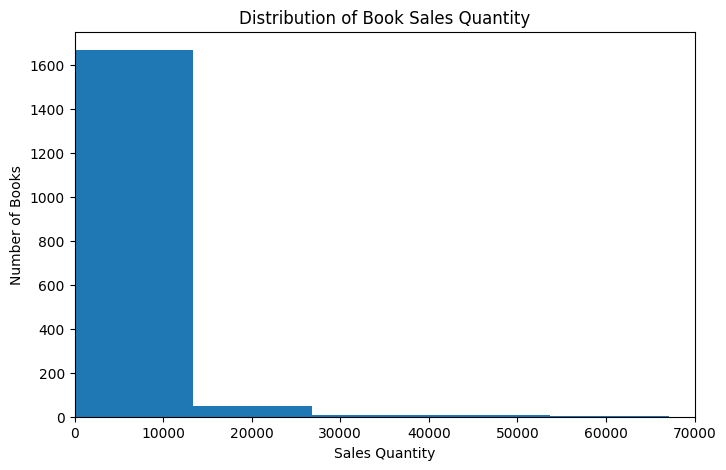

In [30]:
# Check Target Distribution

plt.figure(figsize=(8, 5))
plt.hist(df["quantity"], bins=50)
plt.xlabel("Sales Quantity")
plt.ylabel("Number of Books")
plt.title("Distribution of Book Sales Quantity")
plt.xlim(0, 70000)  
plt.show()


**Comment**: The sales quantity distribution is highly right-skewed, with a small number
of best-selling books accounting for extremely high sales volumes. Most books
have relatively low sales, indicating a long-tail demand pattern. This
characteristic makes exact quantity prediction challenging and motivates
the use of demand-level categorization for decision support.

In [ ]:
df["quantity"].describe()

count     1732.00
mean      2796.83
std      16965.80
min          1.00
25%        173.00
50%        565.50
75%       2127.75
max     671121.00
Name: quantity, dtype: float64

**Comment:** Define demand bucket base on quantity distrubition:
- Around 25% for Low demand and 75% for High Demand

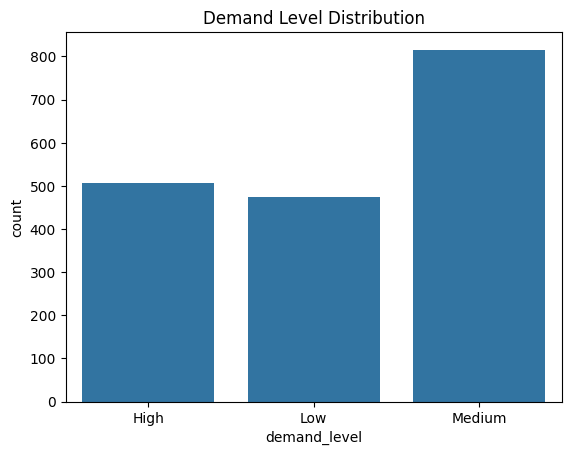

In [ ]:
def demand_bucket(q):
    if q < 200:
        return "Low"
    elif q < 2000:
        return "Medium"
    else:
        return "High"

df["demand_level"] = df["quantity"].apply(demand_bucket)

sns.countplot(x="demand_level", data=df)
plt.title("Demand Level Distribution")
plt.show()


**Comment**: Sales quantities are grouped into Low, Medium, and High demand levels to
reduce noise from extreme values. The distribution shows a balanced spread
across demand levels, supporting its use as a decision-support signal.


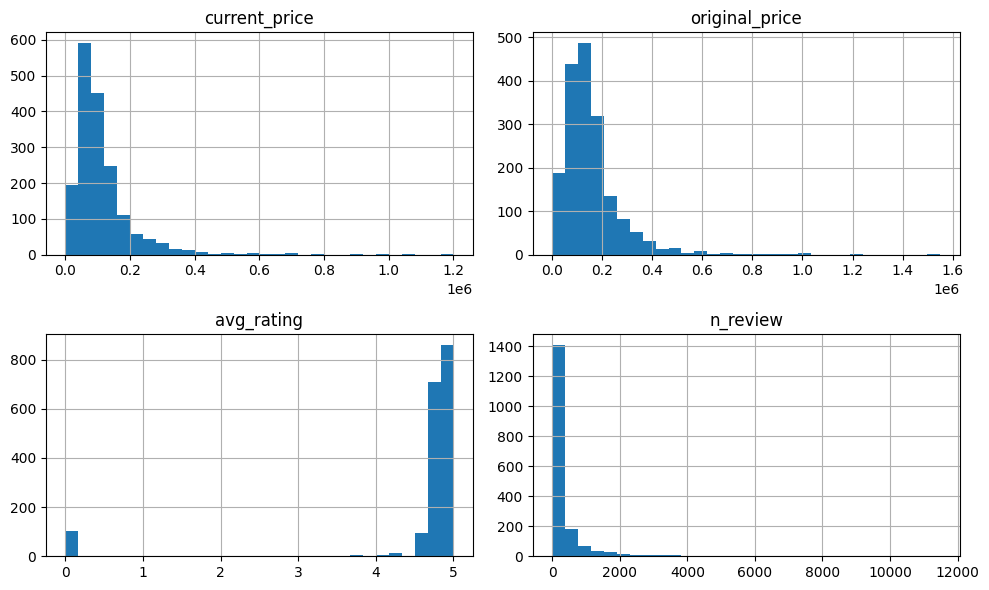

In [ ]:
# Check distribution of main numerical variables

numeric_cols = [
    "current_price",
    "original_price",
    "avg_rating",
    "n_review",
    "pages"
]

df[numeric_cols].hist(figsize=(10,6), bins=30)
plt.tight_layout()
plt.show()


**Comment:** Most numerical features exhibit right-skewed distributions with notable
outliers, especially pricing and review-related variables. Average ratings
are highly concentrated near the upper bound, while the number of reviews
shows a long-tail pattern. These characteristics motivate feature scaling,
regularization, and the use of demand-level categorization instead of exact
quantity prediction.


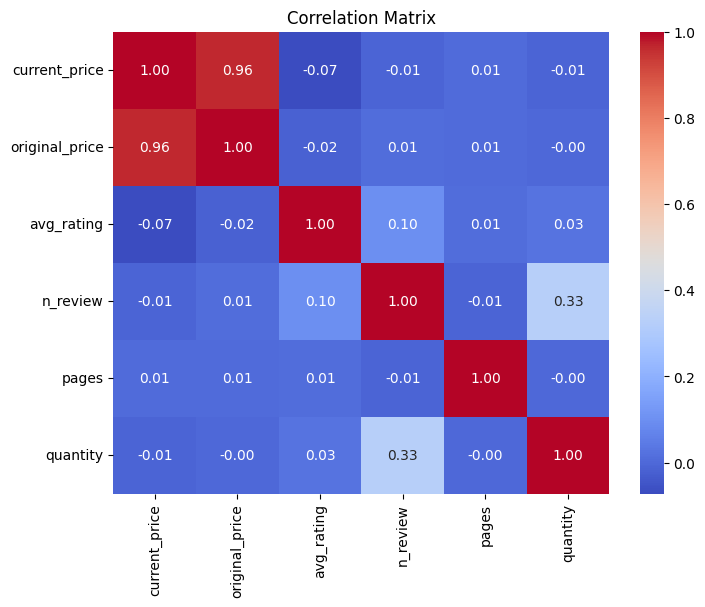

In [ ]:
# Check correlation between variables and target 

plt.figure(figsize=(8,6))
sns.heatmap(
    df[numeric_cols + ["quantity"]].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm"
)
plt.title("Correlation Matrix")
plt.show()


**Commment** : The correlation analysis shows that most features have weak linear
relationships with sales quantity, except for the number of reviews,
which exhibits a moderate positive correlation. Price-related variables
are highly correlated with each other, indicating potential
multicollinearity. These observations support the use of regularized
models and demand-level categorization.


# III. Feature Engineering and Model Building

## 3.1 Feature Engineering

In [ ]:
# Add in 2 new features discount rate and price per page

df["current_price"] = pd.to_numeric(df["current_price"], errors='coerce')
df["original_price"] = pd.to_numeric(df["original_price"], errors='coerce')
df["pages"] = pd.to_numeric(df["pages"], errors='coerce')

df["discount_rate"] = (
    df["original_price"] - df["current_price"]
) / df["original_price"]

df["price_per_page"] = df["current_price"] / df["pages"]

# Handle infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)


In [34]:
df.head()

,product_id,title,authors,original_price,current_price,quantity,category,n_review,avg_rating,pages,manufacturer,cover_link,discount_rate,price_per_page
0,74021317,Cây Cam Ngọt Của Tôi,José Mauro de Vasconcelos,108000,64800,53075.00,Tiểu Thuyết,11481,5.00,244.00,Nhà Xuất Bản Hội Nhà Văn,https://salt.tikicdn.com/ts/product/5e/18/24/2...,0.40,265.57
2,184466860,Hành Tinh Của Một Kẻ Nghĩ Nhiều,Nguyễn Đoàn Minh Thư,86000,59900,7929.00,Sách tư duy - Kỹ năng sống,780,4.80,184.00,Nhà Xuất Bản Thế Giới,https://salt.tikicdn.com/ts/product/d7/99/24/1...,0.30,325.54
3,73787185,Những Tù Nhân Của Địa Lý,Tim Marshall,210000,126000,17896.00,Lĩnh vực khác,3623,4.80,430.00,Nhà Xuất Bản Hội Nhà Văn,https://salt.tikicdn.com/ts/product/8d/96/9e/c...,0.40,293.02
4,52789367,Nhà Giả Kim (Tái Bản 2020),Paulo Coelho,79000,47400,24668.00,Tác phẩm kinh điển,5131,5.00,228.00,Nhà Xuất Bản Hà Nội,https://salt.tikicdn.com/ts/product/45/3b/fc/a...,0.40,207.89
5,147920903,Một Thoáng Ta Rực Rỡ Ở Nhân Gian,NaN,135000,81000,10000.00,Tiểu Thuyết,1636,4.80,304.00,Nhà Xuất Bản Hội Nhà Văn,https://salt.tikicdn.com/ts/product/2f/b5/4e/a...,0.40,266.45


In [35]:
feature_cols = [
    "current_price",
    "original_price",
    "discount_rate",
    "price_per_page",
    "avg_rating",
    "n_review",
    "pages",
    "quantity"
]

corr_df = df[feature_cols].dropna()


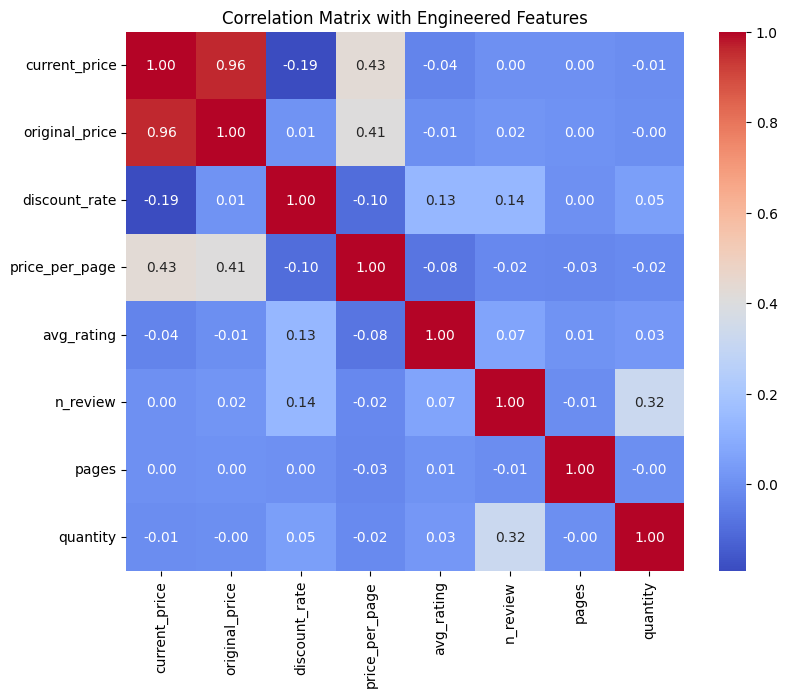

In [36]:

plt.figure(figsize=(9, 7))
sns.heatmap(
    corr_df.corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm"
)
plt.title("Correlation Matrix with Engineered Features")
plt.show()


**Comment**: After feature engineering, derived features such as discount rate and price per
page introduce additional business-relevant signals beyond raw prices. While
linear correlations with sales quantity remain moderate, these features help
reduce multicollinearity and improve model stability. The results further
support the use of regularized models and demand-level outputs instead of exact
quantity prediction.


## 3.2 Data Preparation 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [3]:
#Preprocessing Pipeline
numeric_features = [
    "current_price",
    "original_price",
    "avg_rating",
    "n_review",
    "pages",
    "discount_rate",
    "price_per_page"
]

categorical_features = ["category"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [46]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Ensure numeric types
        X["current_price"] = pd.to_numeric(X["current_price"], errors="coerce")
        X["original_price"] = pd.to_numeric(X["original_price"], errors="coerce")
        X["pages"] = pd.to_numeric(X["pages"], errors="coerce")

        # Feature engineering
        X["discount_rate"] = (
            X["original_price"] - X["current_price"]
        ) / X["original_price"]

        X["price_per_page"] = X["current_price"] / X["pages"]

        # Handle inf values
        X.replace([np.inf, -np.inf], np.nan, inplace=True)

        return X


## Model 1: Linear Regression

In [47]:
# Model 1: Linear Regression

linreg_pipeline = Pipeline(steps=[
    ("feature_engineering", FeatureEngineer()),
    ("preprocessing", preprocessor),
    ("model", LinearRegression())
])


linreg_pipeline.fit(X_train, y_train)

y_pred_lr = linreg_pipeline.predict(X_test)


In [49]:
mae = mean_absolute_error(y_test, y_pred_lr)
rmse = root_mean_squared_error(y_test, y_pred_lr)
r2 = r2_score(y_test, y_pred_lr)

print("Linear Regression Results")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.3f}")


Linear Regression Results
MAE: 1825.89
RMSE: 4476.03
R2: 0.436


**Comment**: The linear model serves as a useful baseline for understanding overall demand
trends but lacks the flexibility to handle noisy and highly skewed sales data,
limiting its accuracy for precise quantity prediction.


## Model 2: Ridge Regression

In [51]:
#Model 2: Ridge Regression

ridge_pipeline = Pipeline(steps=[
    ("feature_engineering", FeatureEngineer()),
    ("preprocessing", preprocessor),
    ("model", Ridge(alpha=1.0))
])


ridge_pipeline.fit(X_train, y_train)
y_pred_ridge = ridge_pipeline.predict(X_test)


In [52]:
print("Ridge Regression Results")
print(f"MAE: {mean_absolute_error(y_test, y_pred_ridge):.2f}")
print(f"RMSE: {root_mean_squared_error(y_test, y_pred_ridge):.2f}")
print(f"R2: {r2_score(y_test, y_pred_ridge):.3f}")

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = root_mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)


Ridge Regression Results
MAE: 1733.64
RMSE: 4379.94
R2: 0.460


**Comment**: Ridge Regression outperforms Linear Regression by reducing prediction error and
slightly increasing explanatory power. This suggests that regularization is
effective in handling multicollinearity and improving model robustness.


## Model 3: Simple DL Model

In [6]:
#Test DL model
from sklearn.neural_network import MLPRegressor


In [7]:
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    max_iter=500,
    random_state=42
)


In [60]:
mlp_pipeline = Pipeline(steps=[
    ("feature_engineering", FeatureEngineer()),
    ("preprocessing", preprocessor),
    ("model", mlp)
])

mlp_pipeline.fit(X_train, y_train)

y_pred_mlp = mlp_pipeline.predict(X_test)


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [61]:
# Lấy model ra khỏi pipeline
trained_mlp = mlp_pipeline.named_steps["model"]


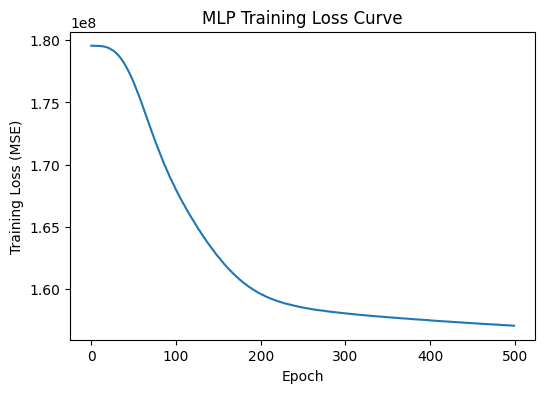

In [62]:

plt.figure(figsize=(6, 4))
plt.plot(trained_mlp.loss_curve_)
plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("MLP Training Loss Curve")
plt.show()


In [63]:
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
rmse_mlp = root_mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

mae_mlp, rmse_mlp, r2_mlp

(1449.9743875824634, 3484.9606301015565, 0.6581933849179484)

In [64]:
comparison_df = pd.DataFrame({
    "Model": ["Ridge Regression", "Neural Network (MLP)"],
    "MAE": [mae_ridge, mae_mlp],
    "RMSE": [rmse_ridge, rmse_mlp],
    "R2": [r2_ridge, r2_mlp]
})

comparison_df


,Model,MAE,RMSE,R2
0,Ridge Regression,1733.64,4379.94,0.46
1,Neural Network (MLP),1449.97,3484.96,0.66


**Comment** The MLP model outperforms Ridge Regression across all metrics, indicating its
ability to capture non-linear demand patterns. Despite this improvement, Ridge
Regression remains a robust and interpretable baseline for decision support.


### 3.4 Mapping Predicted Sales to Demand Levels and Evaluation

In [ ]:
def demand_bucket(qty):
    if qty >= 2000:
        return "High"
    elif qty >= 500:
        return "Medium"
    else:
        return "Low"

In [70]:
# Convert predictions to DataFrame
result_df = pd.DataFrame({
    "actual_quantity": y_test,
    "predicted_quantity": y_pred_mlp
})

result_df["actual_bucket"] = result_df["actual_quantity"].apply(demand_bucket)
result_df["predicted_bucket"] = result_df["predicted_quantity"].apply(demand_bucket)

result_df.head()

,actual_quantity,predicted_quantity,actual_bucket,predicted_bucket
626,1012.00,838.01,Medium,Medium
1776,258.00,178.97,Low,Low
655,1722.00,239.57,Medium,Low
1553,38.00,1147.34,Low,Medium
1617,104.00,633.13,Low,Medium


In [69]:
labels = ["Low", "Medium", "High"]

cm = confusion_matrix(
    result_df["actual_bucket"],
    result_df["predicted_bucket"],
    labels=labels
)

cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df


,Low,Medium,High
Low,94,67,8
Medium,19,42,27
High,1,7,82


In [68]:
print(classification_report(
    result_df["actual_bucket"],
    result_df["predicted_bucket"],
    labels=labels
))

              precision    recall  f1-score   support

         Low       0.82      0.56      0.66       169
      Medium       0.36      0.48      0.41        88
        High       0.70      0.91      0.79        90

    accuracy                           0.63       347
   macro avg       0.63      0.65      0.62       347
weighted avg       0.68      0.63      0.63       347



**Comment** : From a business perspective, the model is effective at flagging high-demand
products that require inventory attention. Misclassifications mainly occur in
the Medium category, which is less critical for risk management. The system is
best used as a decision-support tool to prioritize stocking strategies.


## Saving model for deployment: Using MLP model

In [17]:
from src.feature_engineering import FeatureEngineer
import joblib

full_pipeline = Pipeline(steps=[
    ("feature_engineering", FeatureEngineer()),
    ("preprocessing", preprocessor),
    ("model", mlp)
])

full_pipeline.fit(X_train, y_train)


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('feature_engineering', ...), ('preprocessing', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the diffe

In [18]:
joblib.dump(full_pipeline, "models/book_demand_model.pkl")

['models/book_demand_model.pkl']

### Appendix

http://127.0.0.1:8000/docs

python -m uvicorn app.api:app --reload
